# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.

Напишите короткую интерпретацию полученных результатов: какие паттерны в матрицах внимания вы видите? как эти паттерны отличаются между слоями? как они меняются с каждой эпохой?
Постарайтесь найти какое-то хорошее предложение, для которого у вас заранее есть какое-то представление о связях между словами и которое вы сможете сравнить со скорами внимания (например, какую синтаксическую конструкцию)

Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

## 1. Загрузка и подготовка данных

In [ ]:
!pip3 install rusenttokenize

In [ ]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

data = pd.read_csv(
    'https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

In [ ]:
sentences = open('corpus.txt').read().splitlines()
print(f"Всего предложений: {len(sentences)}")

Всего предложений: 491362


## 2. Токенизация

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

# Инициализируем токенизатор и тренер
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    special_tokens=[
        "[PAD]",
        "[BOS]",
        "[EOS]"],
    end_of_word_suffix='')

In [ ]:
# Обучаем токенизатор на нашем корпусе
tokenizer.train(files=["corpus.txt"], trainer=trainer)
tokenizer.save('tokenizer')

In [ ]:
# Перезагружаем
tokenizer = Tokenizer.from_file("tokenizer")
tokenizer.decoder = decoders.BPEDecoder()

vocab_size = tokenizer.get_vocab_size()
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [ ]:
# Функция для токенизации
def encode(text, tokenizer):
    return [tokenizer.token_to_id(
        '[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

## 3. Готовим датасеты и делим на выборки

In [ ]:
import torch
import random


class Dataset(torch.utils.data.Dataset):
    def __init__(self, sentences, tokenizer, max_len=32):
        self.encoded_texts = [torch.LongTensor(
            encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        self.X = torch.nn.utils.rnn.pad_sequence(
            self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        x = self.X[index][:-1]
        y = self.X[index][1:]
        mask = x != PAD_IDX
        return x, y, mask

In [ ]:
# Перемешиваем и делаем выборки
random.seed(42)
random.shuffle(sentences)

n = int(0.9 * len(sentences))
sentences_train = sentences[:n]
sentences_val = sentences[n:]

MAX_LEN = 64
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [ ]:
# Даталоадеры
training_generator = torch.utils.data.DataLoader(
    training_set, batch_size=256, shuffle=True)
val_generator = torch.utils.data.DataLoader(
    val_set, batch_size=256, shuffle=False)

## 4. Выбираем таргетное предложение

Я решил выбрать из валидационной выборки 20 случайных предложений, посмотреть на них, и выбрать самое удачное.

In [ ]:
candidates = random.sample(sentences_val, 20)
for i, cand in enumerate(candidates):
    print(f"{i}: {cand}")

0: В результате переговоров инцидент завершился мирно.
1: Сама Таисия Осипова и свидетель, находившийся вместе с ней дома во время обыска, настаивают, что наркотики были подброшены.
2: Антигипертритон, в свою очередь, - это антидвойник гипертритона, состоящий из антипротона, антинейтрона и антигиперона.
3: Инициатором его проведения стали  Музей истории Москвы и Союз театральных деятелей РФ.
4: 
5: Версии причин убийства разнятся.
6: С тех пор с молотка за 103,5 миллиона рублей ушел лишь один квартал в районе улицы Лени Голикова.
7: Впрочем, сам осужденный настаивал на том, что не виновен.
8: Авария на Краснохолмском мосту произошла 31 июля.
9: Agence France-Presse передает, что чиновник в администрации премьер-министра назвал произошедшие перестановки "незначительным перераспределением портфелей".
10: «Идиоты!
11: Региональное управление Госавтоинспекции приняло участие во всероссийской пропагандистской акции ведомства под названием «Пристегнись, Россия!». Для этого красноярский парк 

Будем анализировать внимание на таком предложении: *Сама Таисия Осипова и свидетель, находившийся вместе с ней дома во время обыска, настаивают, что наркотики были подброшены*. Оно синтаксически довольно сложное, с причастным оборотом, но при этом там нет каких-то суперсложных научных и других терминов.

In [ ]:
target_sentence = candidates[1]

target_tokens = encode(target_sentence, tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_tensor = torch.LongTensor([target_tokens]).to(device)

tokens_for_viz = [tokenizer.id_to_token(t) for t in target_tokens]
print(tokens_for_viz)

['[BOS]', 'Сама', 'Та', 'и', 'сия', 'Оси', 'пова', 'и', 'свидетель', ',', 'находившийся', 'вместе', 'с', 'ней', 'дома', 'во', 'время', 'обыска', ',', 'настаивают', ',', 'что', 'наркотики', 'были', 'под', 'бро', 'шены', '.', '[EOS]']


Токенизатор не научился до конца работать с именами и деепричастиями, но так даже интереснее.

## 5. Модель

Комменты в коде есть ко всем изменённым частям относительно оригинала.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

block_size = MAX_LEN
learning_rate = 1e-3
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

In [ ]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer(
            'tril', torch.tril(
                torch.ones(
                    block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        if mask is not None:
            wei = wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei_dropped = self.dropout(wei)
        v = self.value(x)
        out = wei_dropped @ v

        # Пробрасываем матрицу внимания дальше
        return out, wei


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Собираем выходы и веса со всех голов внимания
        head_outputs = [h(x, mask) for h in self.heads]
        out = torch.cat([h[0] for h in head_outputs], dim=-1)
        attentions = torch.stack([h[1] for h in head_outputs])

        out = self.dropout(self.proj(out))
        return out, attentions


class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        x, mask = inp
        # Берём веса внимания из MHA
        sa_out, attentions = self.sa(self.ln1(x), mask)
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return x, mask, attentions


class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        # Меняем Sequential на ModuleList для доступа к выходам каждого блока
        self.blocks = nn.ModuleList(
            [Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # Атрибут для хранения весов
        self.last_attentions = None

    def forward(self, idx, targets=None, mask=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb

        all_attentions = []
        for block in self.blocks:
            x, mask, attn = block((x, mask))
            all_attentions.append(attn)

        # Формируем итоговый тензор весов: слой -> голова -> батч -> токен ->
        # токен
        self.last_attentions = torch.stack(all_attentions)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss

## 6. Цикл обучения

In [ ]:
from tqdm.notebook import tqdm

model = GPTLanguageModel()
m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()
    for i, (xs, ys, mask) in enumerate(
            tqdm(iterator, desc="Training", leave=False)):
        optimizer.zero_grad()
        logits, loss = model(xs.to(device), ys.to(device), mask.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        if not (i + 1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')
    return torch.Tensor(epoch_loss).mean(-1)


def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in tqdm(iterator, desc="Evaluating", leave=False):
            logits, loss = model(xs.to(device), ys.to(device), mask.to(device))
            epoch_loss.append(loss.item())
    return torch.Tensor(epoch_loss).mean(-1)

## 7. Обучаем

In [ ]:
train_losses = []
eval_losses = []

# Список для хранения матриц внимания после каждой эпохи
history_attentions = []

for i in range(10):
    print(f"Epoch {i}")
    train_losses.append(train(model, training_generator, optimizer, 100))
    eval_loss = evaluate(model, val_generator)
    eval_losses.append(eval_loss)

    # Прогоняем модель на целевом предложении и сохраняем веса
    model.eval()
    with torch.no_grad():
        _ = model(target_tensor)
        history_attentions.append(model.last_attentions.cpu())

Epoch 0


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 8.475518226623535
Loss: 8.069679260253906
Loss: 7.872931957244873
Loss: 7.729797840118408
Loss: 7.609169960021973
Loss: 7.507593631744385
Loss: 7.418783664703369
Loss: 7.336751937866211
Loss: 7.261449813842773
Loss: 7.190000534057617
Loss: 7.124719142913818
Loss: 7.0639543533325195
Loss: 7.004621505737305
Loss: 6.949111461639404
Loss: 6.8967108726501465
Loss: 6.847000598907471
Loss: 6.799648284912109


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 1


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 5.945915699005127
Loss: 5.9232940673828125
Loss: 5.904370307922363
Loss: 5.885447978973389
Loss: 5.867583274841309
Loss: 5.8498215675354
Loss: 5.832655429840088
Loss: 5.817709922790527
Loss: 5.803414821624756
Loss: 5.789022922515869
Loss: 5.774357795715332
Loss: 5.7608795166015625
Loss: 5.7473530769348145
Loss: 5.734557628631592
Loss: 5.721660137176514
Loss: 5.709222316741943
Loss: 5.69751501083374


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 2


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 5.422624111175537
Loss: 5.422330856323242
Loss: 5.418306350708008
Loss: 5.413782119750977
Loss: 5.408648490905762
Loss: 5.403154373168945
Loss: 5.398771286010742
Loss: 5.394396781921387
Loss: 5.389534950256348
Loss: 5.38395881652832
Loss: 5.378579139709473
Loss: 5.37349796295166
Loss: 5.368093490600586
Loss: 5.363266468048096
Loss: 5.358449459075928
Loss: 5.353341579437256
Loss: 5.3487467765808105


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 3


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 5.194705009460449
Loss: 5.197167873382568
Loss: 5.197311878204346
Loss: 5.195944309234619
Loss: 5.193666934967041
Loss: 5.192849159240723
Loss: 5.191701412200928
Loss: 5.189498424530029
Loss: 5.188069820404053
Loss: 5.186586380004883
Loss: 5.184779167175293
Loss: 5.1820454597473145
Loss: 5.180662631988525
Loss: 5.178138732910156
Loss: 5.176254749298096
Loss: 5.173738956451416
Loss: 5.17157506942749


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 4


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 5.061322212219238
Loss: 5.06626558303833
Loss: 5.065788269042969
Loss: 5.063281536102295
Loss: 5.063594818115234
Loss: 5.064401626586914
Loss: 5.063029766082764
Loss: 5.063936710357666
Loss: 5.0618486404418945
Loss: 5.061652183532715
Loss: 5.060140132904053
Loss: 5.059852123260498
Loss: 5.059325218200684
Loss: 5.058293342590332
Loss: 5.056625843048096
Loss: 5.055298805236816
Loss: 5.053919315338135


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 5


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 4.964383602142334
Loss: 4.963955879211426
Loss: 4.9655327796936035
Loss: 4.969380855560303
Loss: 4.970109939575195
Loss: 4.971751689910889
Loss: 4.972229480743408
Loss: 4.971508502960205
Loss: 4.970848083496094
Loss: 4.9707417488098145
Loss: 4.971194267272949
Loss: 4.970954418182373
Loss: 4.97092866897583
Loss: 4.969675540924072
Loss: 4.968677520751953
Loss: 4.9687910079956055
Loss: 4.967822074890137


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 6


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 4.8876776695251465
Loss: 4.890007972717285
Loss: 4.893130302429199
Loss: 4.898144721984863
Loss: 4.899190425872803
Loss: 4.899867534637451
Loss: 4.900261402130127
Loss: 4.902685642242432
Loss: 4.903926372528076
Loss: 4.903299331665039
Loss: 4.903512001037598
Loss: 4.9037957191467285
Loss: 4.903792381286621
Loss: 4.9037065505981445
Loss: 4.903145790100098
Loss: 4.902950763702393
Loss: 4.902795791625977


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 7


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 4.831239700317383
Loss: 4.8318986892700195
Loss: 4.8331403732299805
Loss: 4.835420608520508
Loss: 4.83991003036499
Loss: 4.841620445251465
Loss: 4.8420610427856445
Loss: 4.844319820404053
Loss: 4.846690654754639
Loss: 4.847620010375977
Loss: 4.848232746124268
Loss: 4.848911762237549
Loss: 4.849939346313477
Loss: 4.849554538726807
Loss: 4.849600315093994
Loss: 4.850217342376709
Loss: 4.850310802459717


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 8


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 4.783268928527832
Loss: 4.790881633758545
Loss: 4.790806293487549
Loss: 4.793121337890625
Loss: 4.795342922210693
Loss: 4.797422885894775
Loss: 4.798206806182861
Loss: 4.800149440765381
Loss: 4.801100730895996
Loss: 4.802582740783691
Loss: 4.80374002456665
Loss: 4.803983211517334
Loss: 4.805026054382324
Loss: 4.805696487426758
Loss: 4.806307792663574
Loss: 4.807079315185547
Loss: 4.807431697845459


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Epoch 9


Training:   0%|          | 0/1728 [00:00<?, ?it/s]

Loss: 4.740741729736328
Loss: 4.747384548187256
Loss: 4.7489728927612305
Loss: 4.752477645874023
Loss: 4.756769180297852
Loss: 4.759883403778076
Loss: 4.762218475341797
Loss: 4.763336181640625
Loss: 4.765311241149902
Loss: 4.766280174255371
Loss: 4.76767635345459
Loss: 4.768405437469482
Loss: 4.769596576690674
Loss: 4.76999044418335
Loss: 4.769863128662109
Loss: 4.770749568939209
Loss: 4.771353244781494


Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

## 8. Визуализация

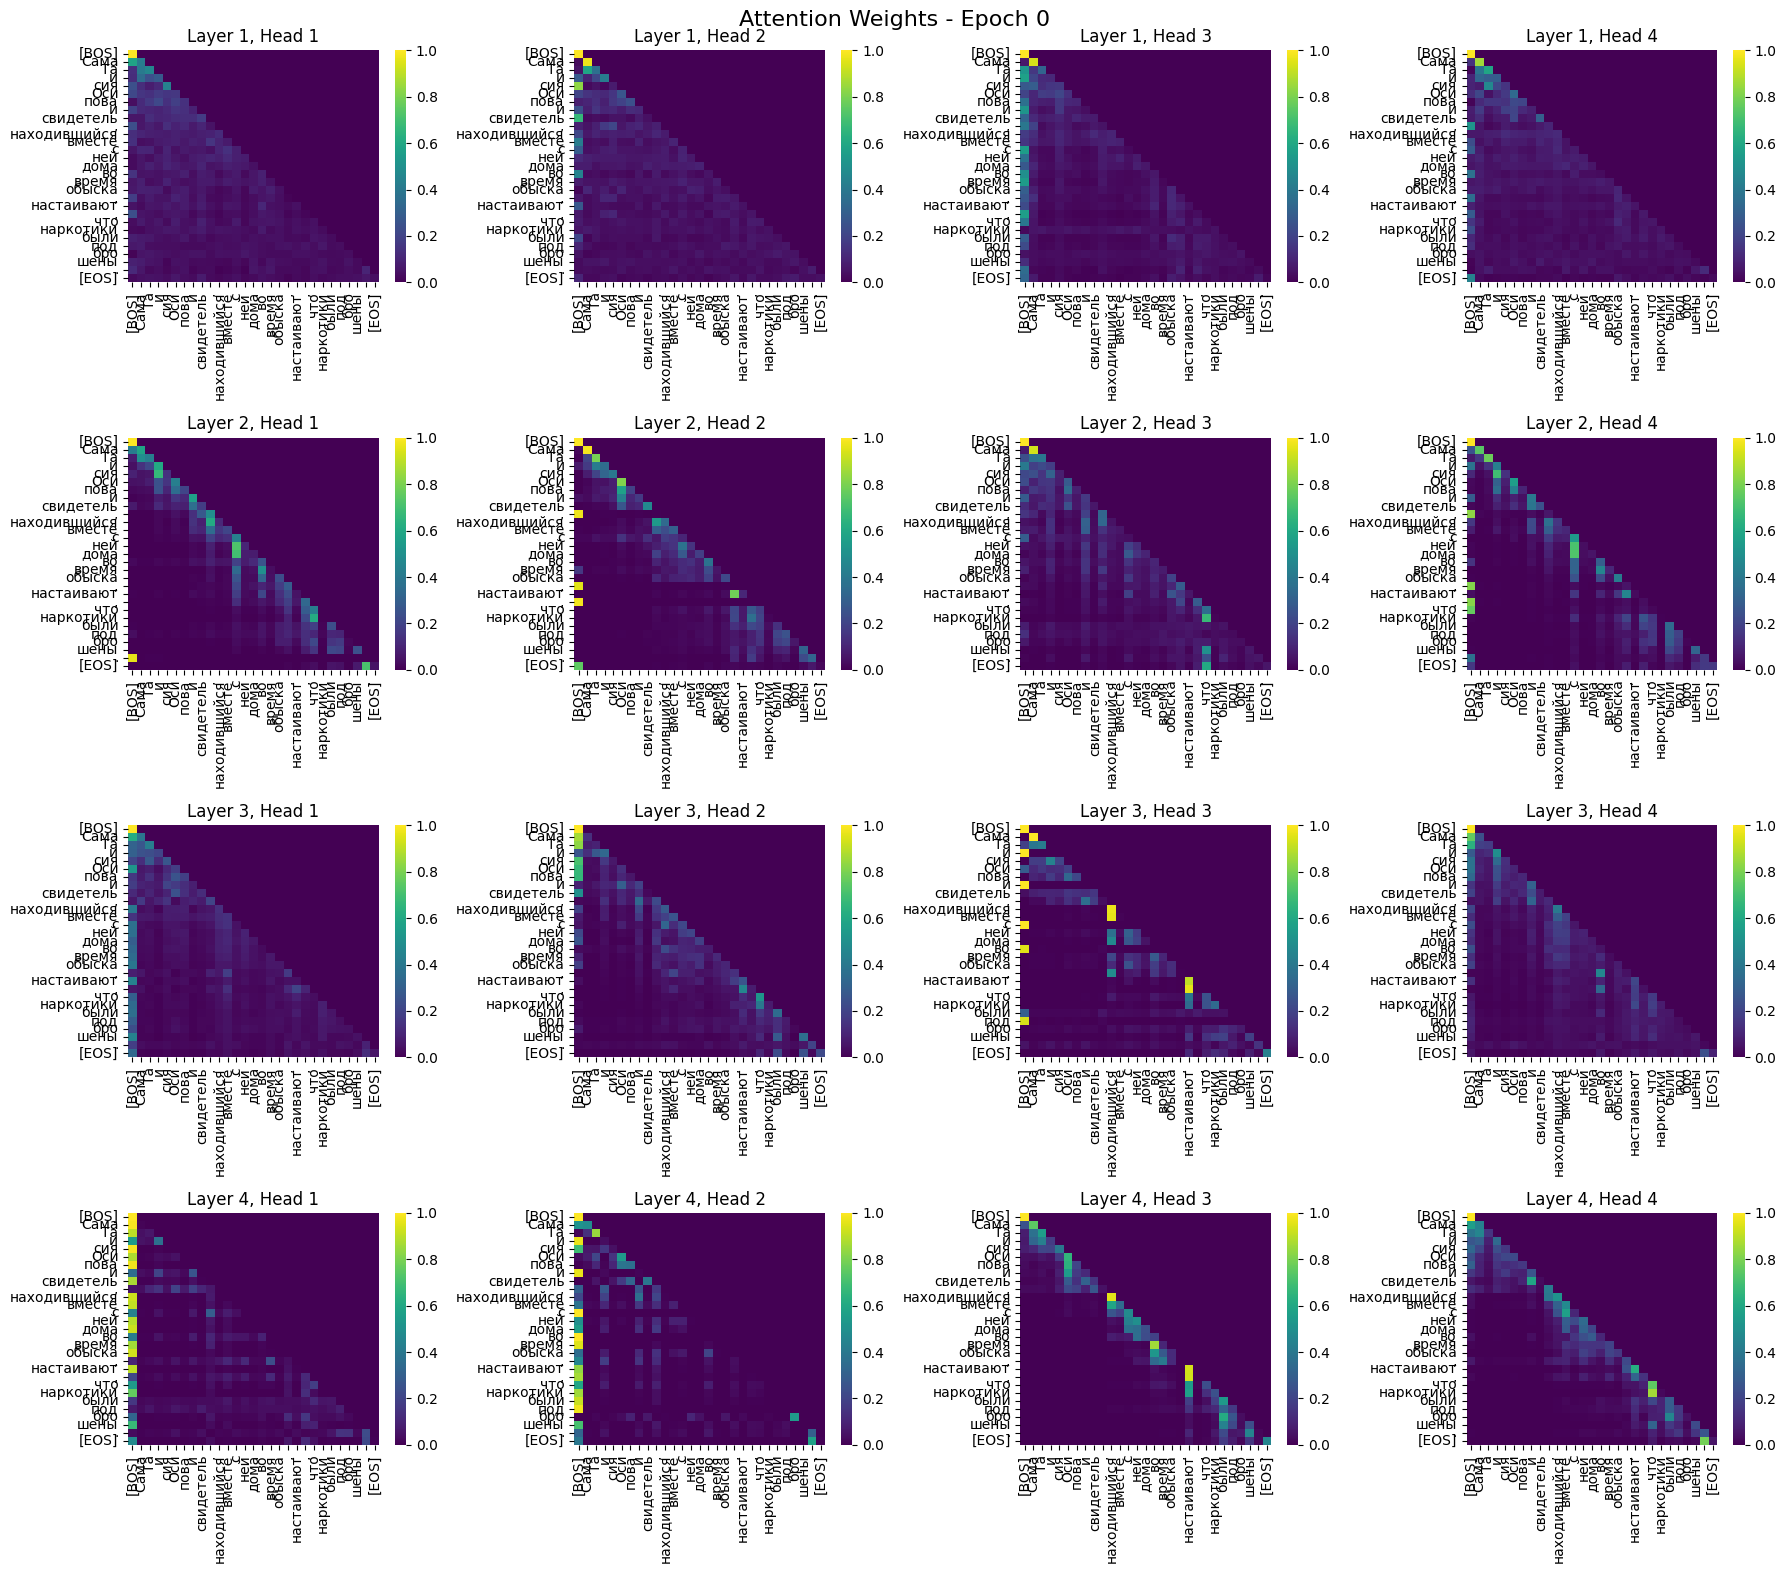

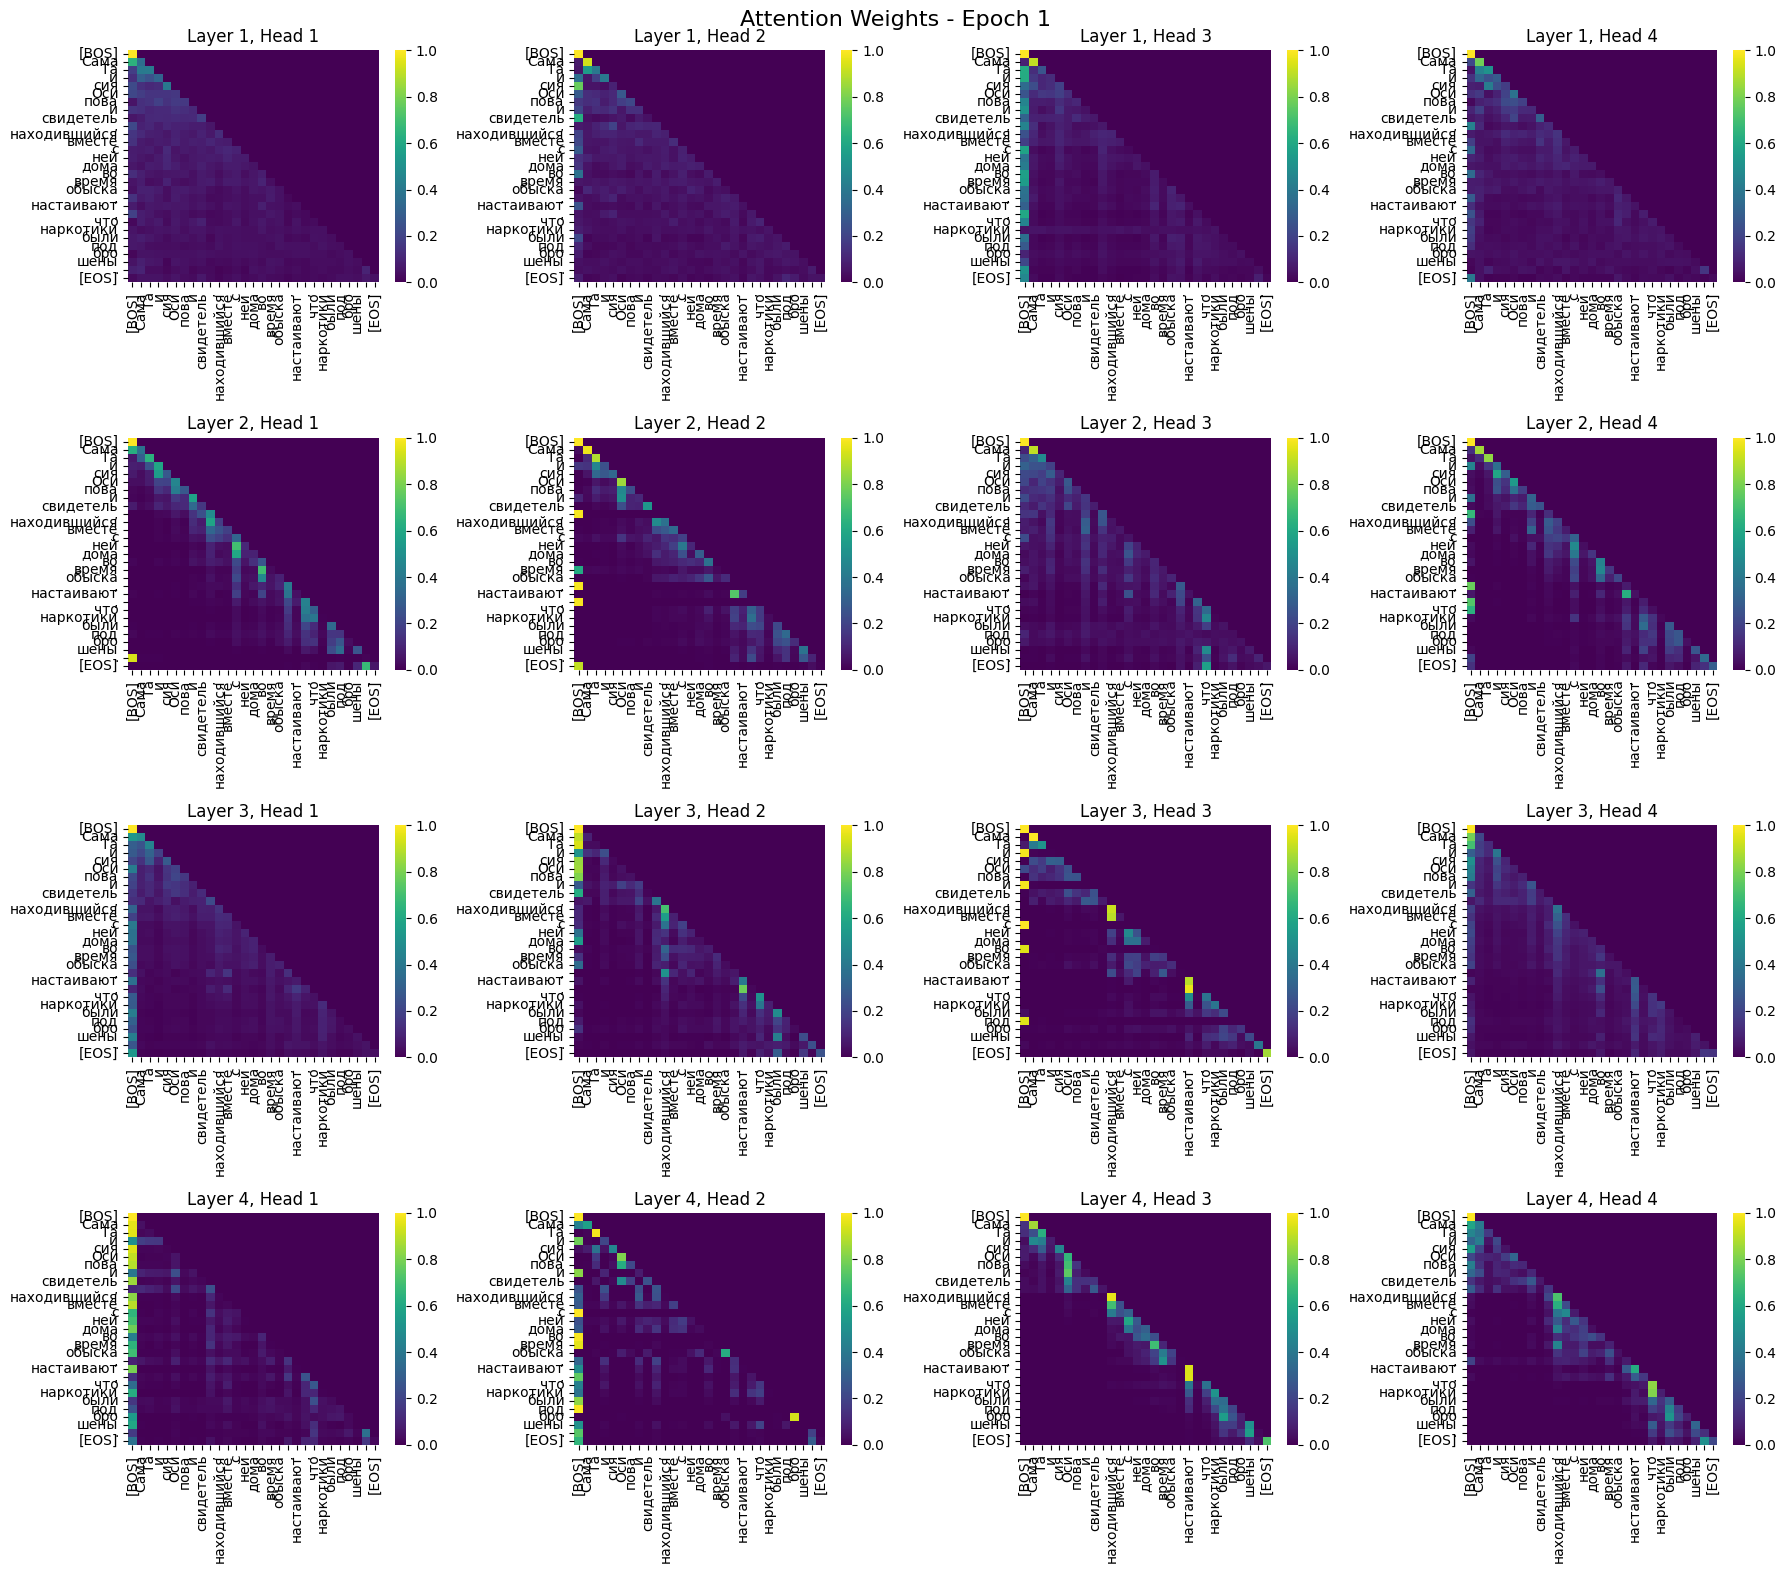

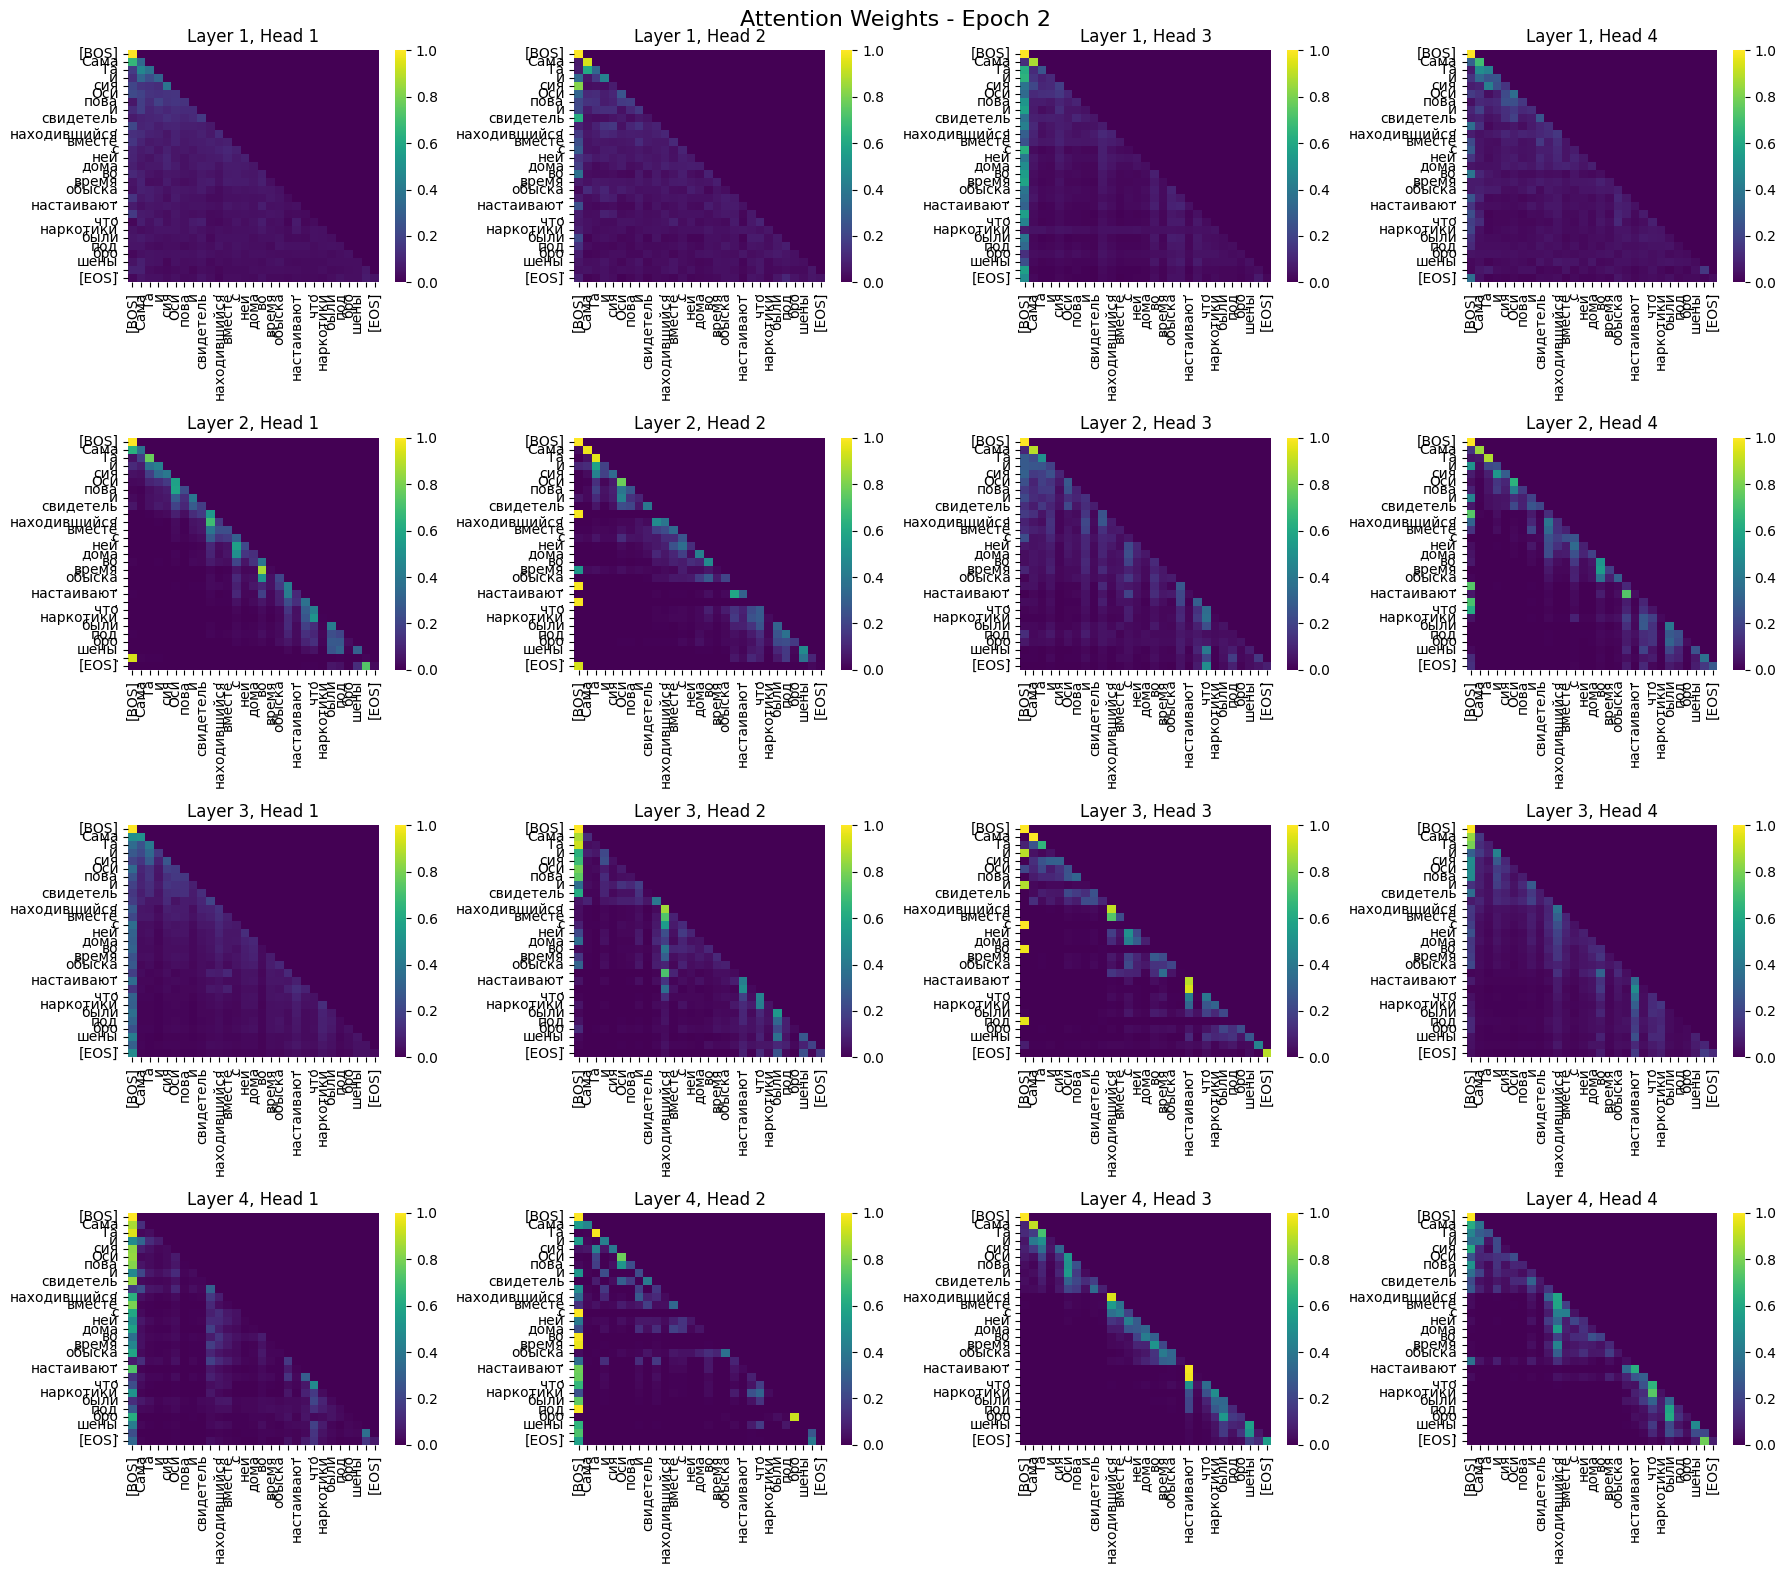

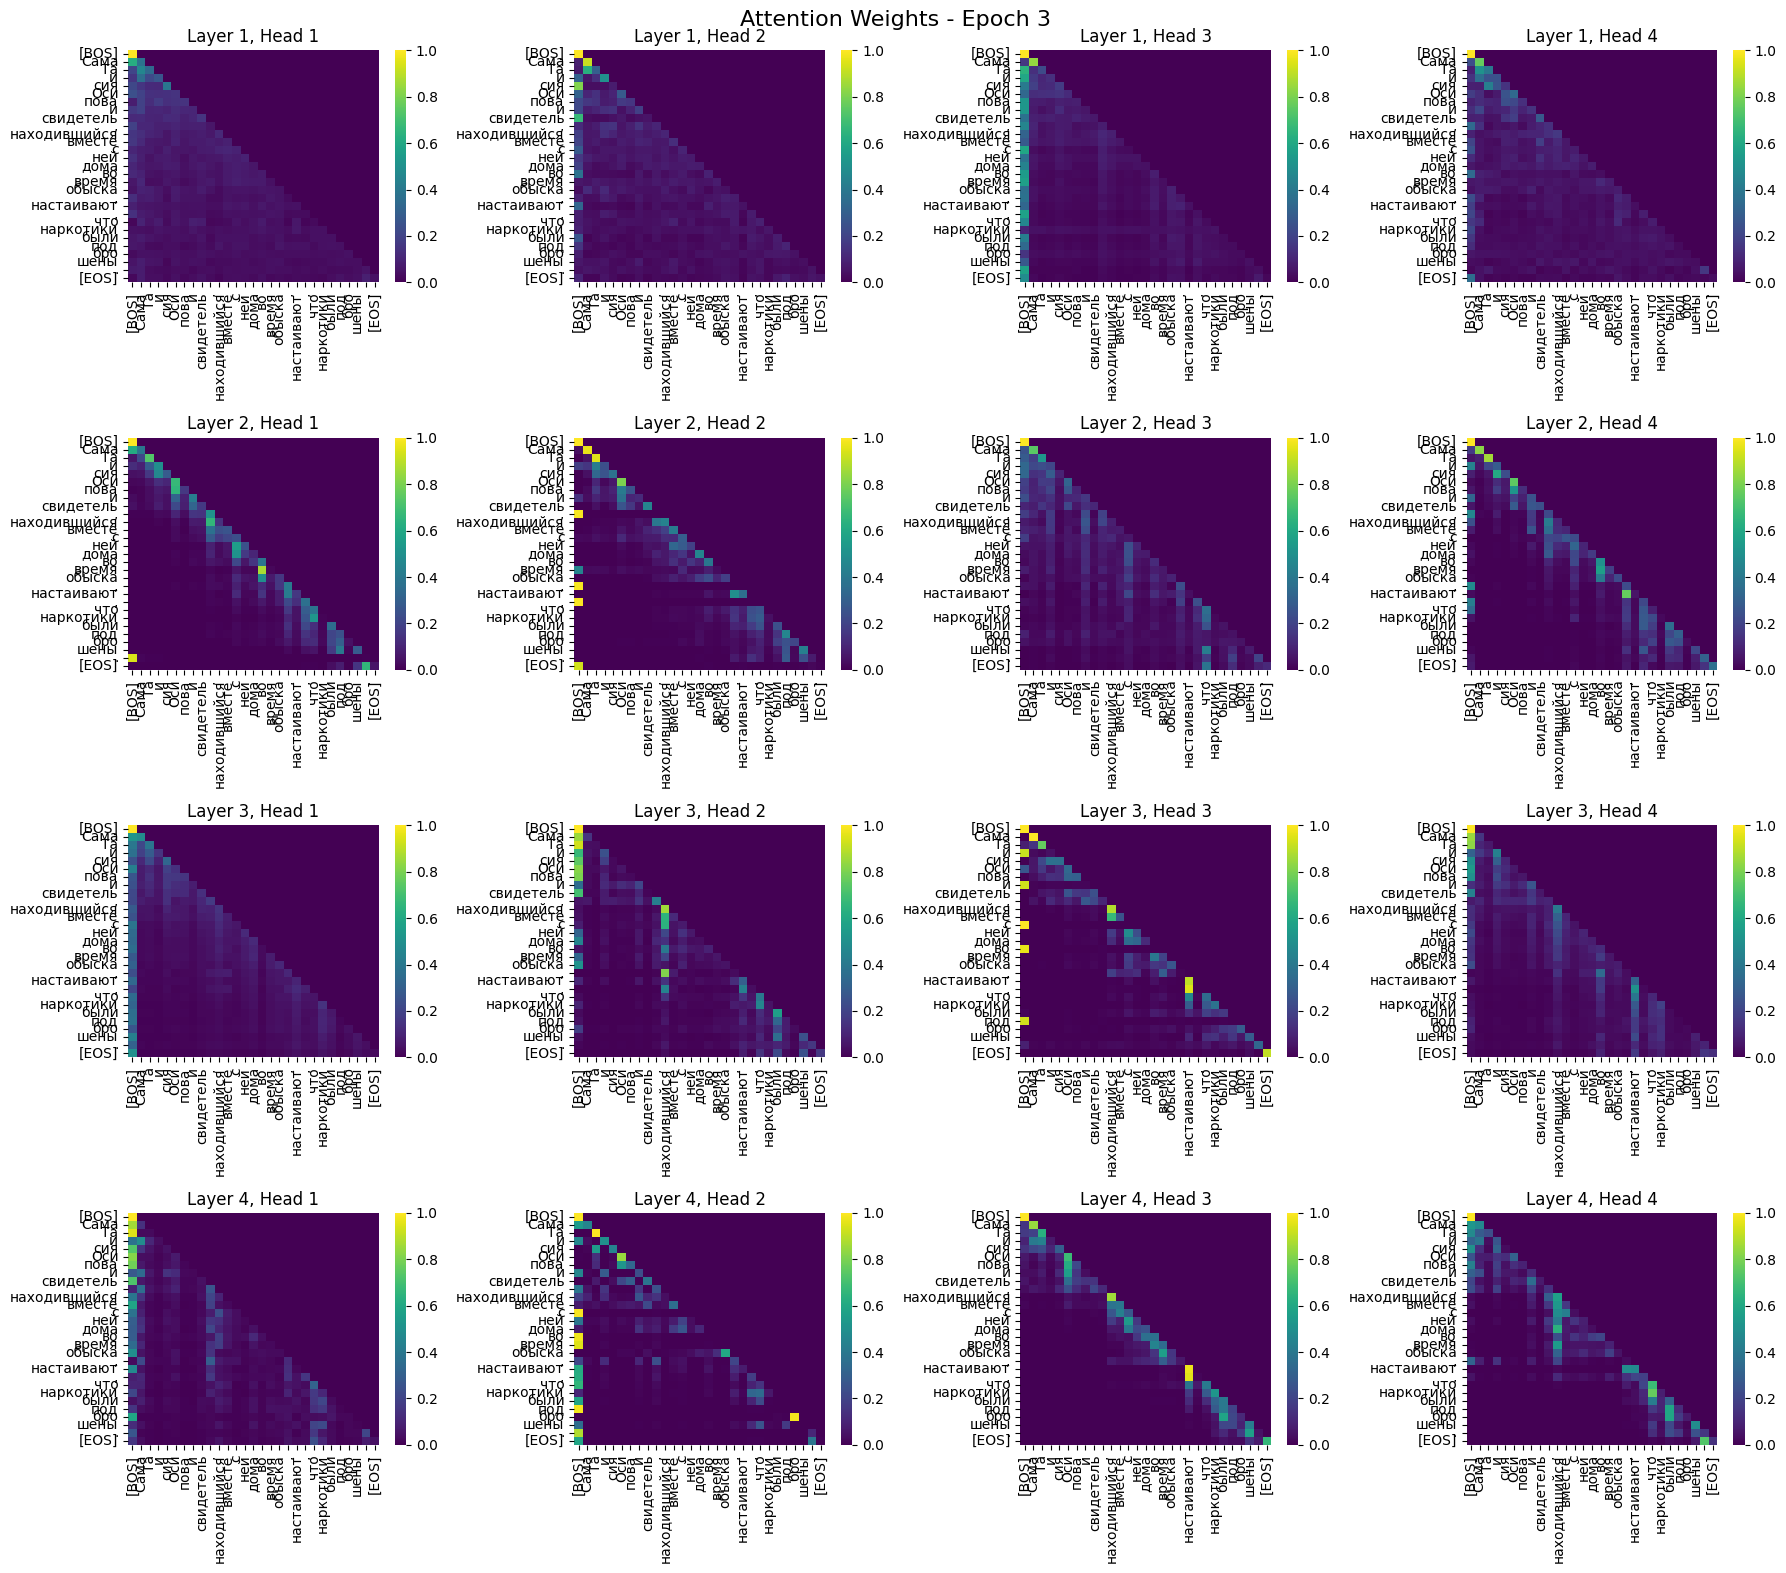

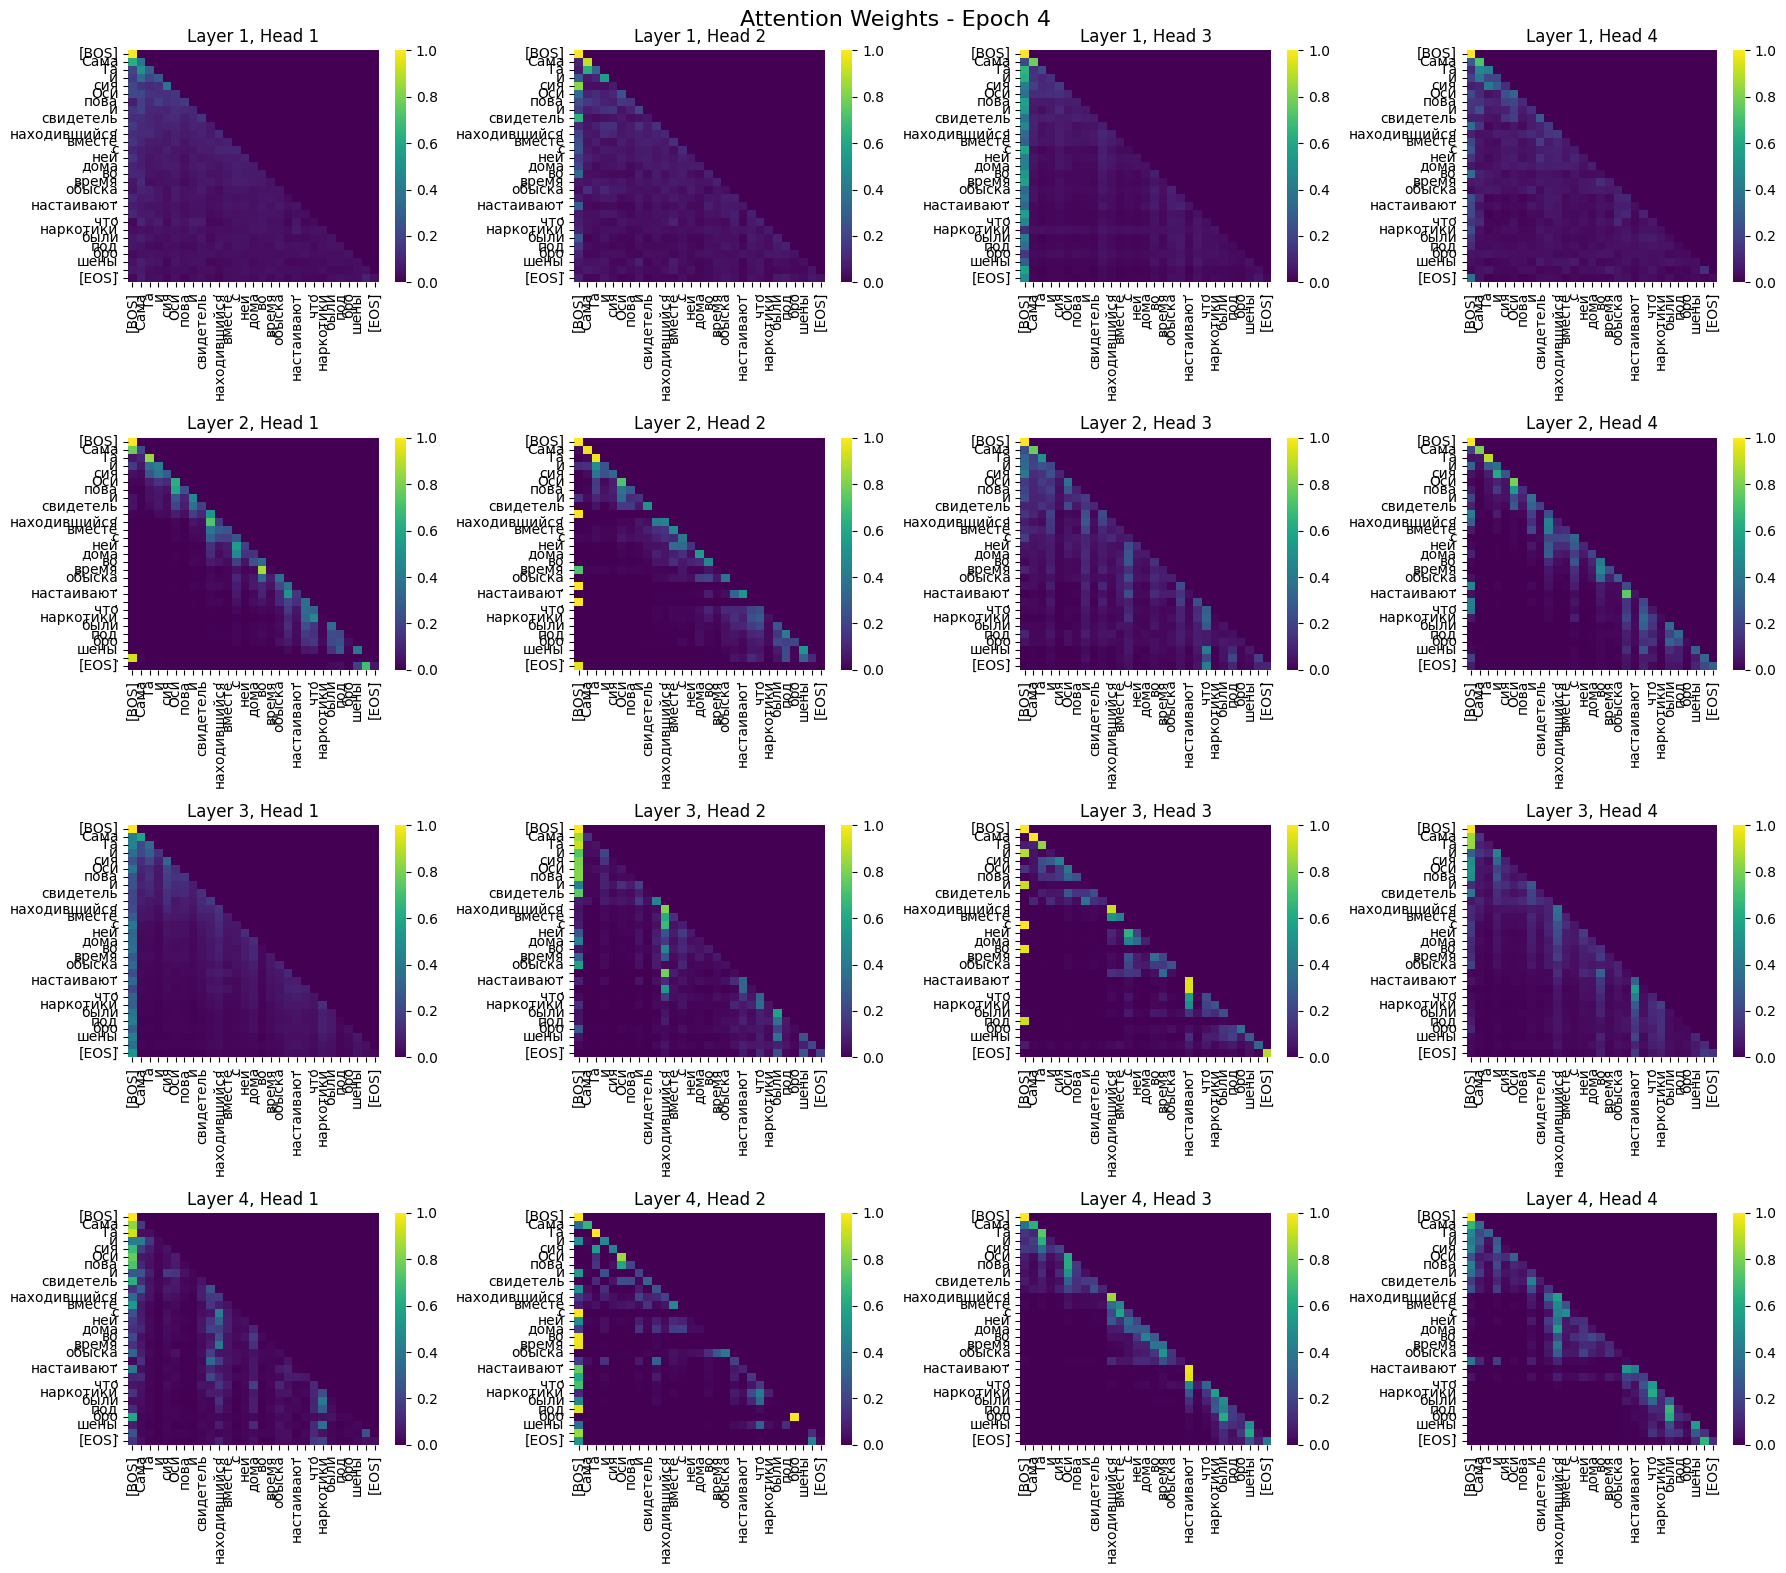

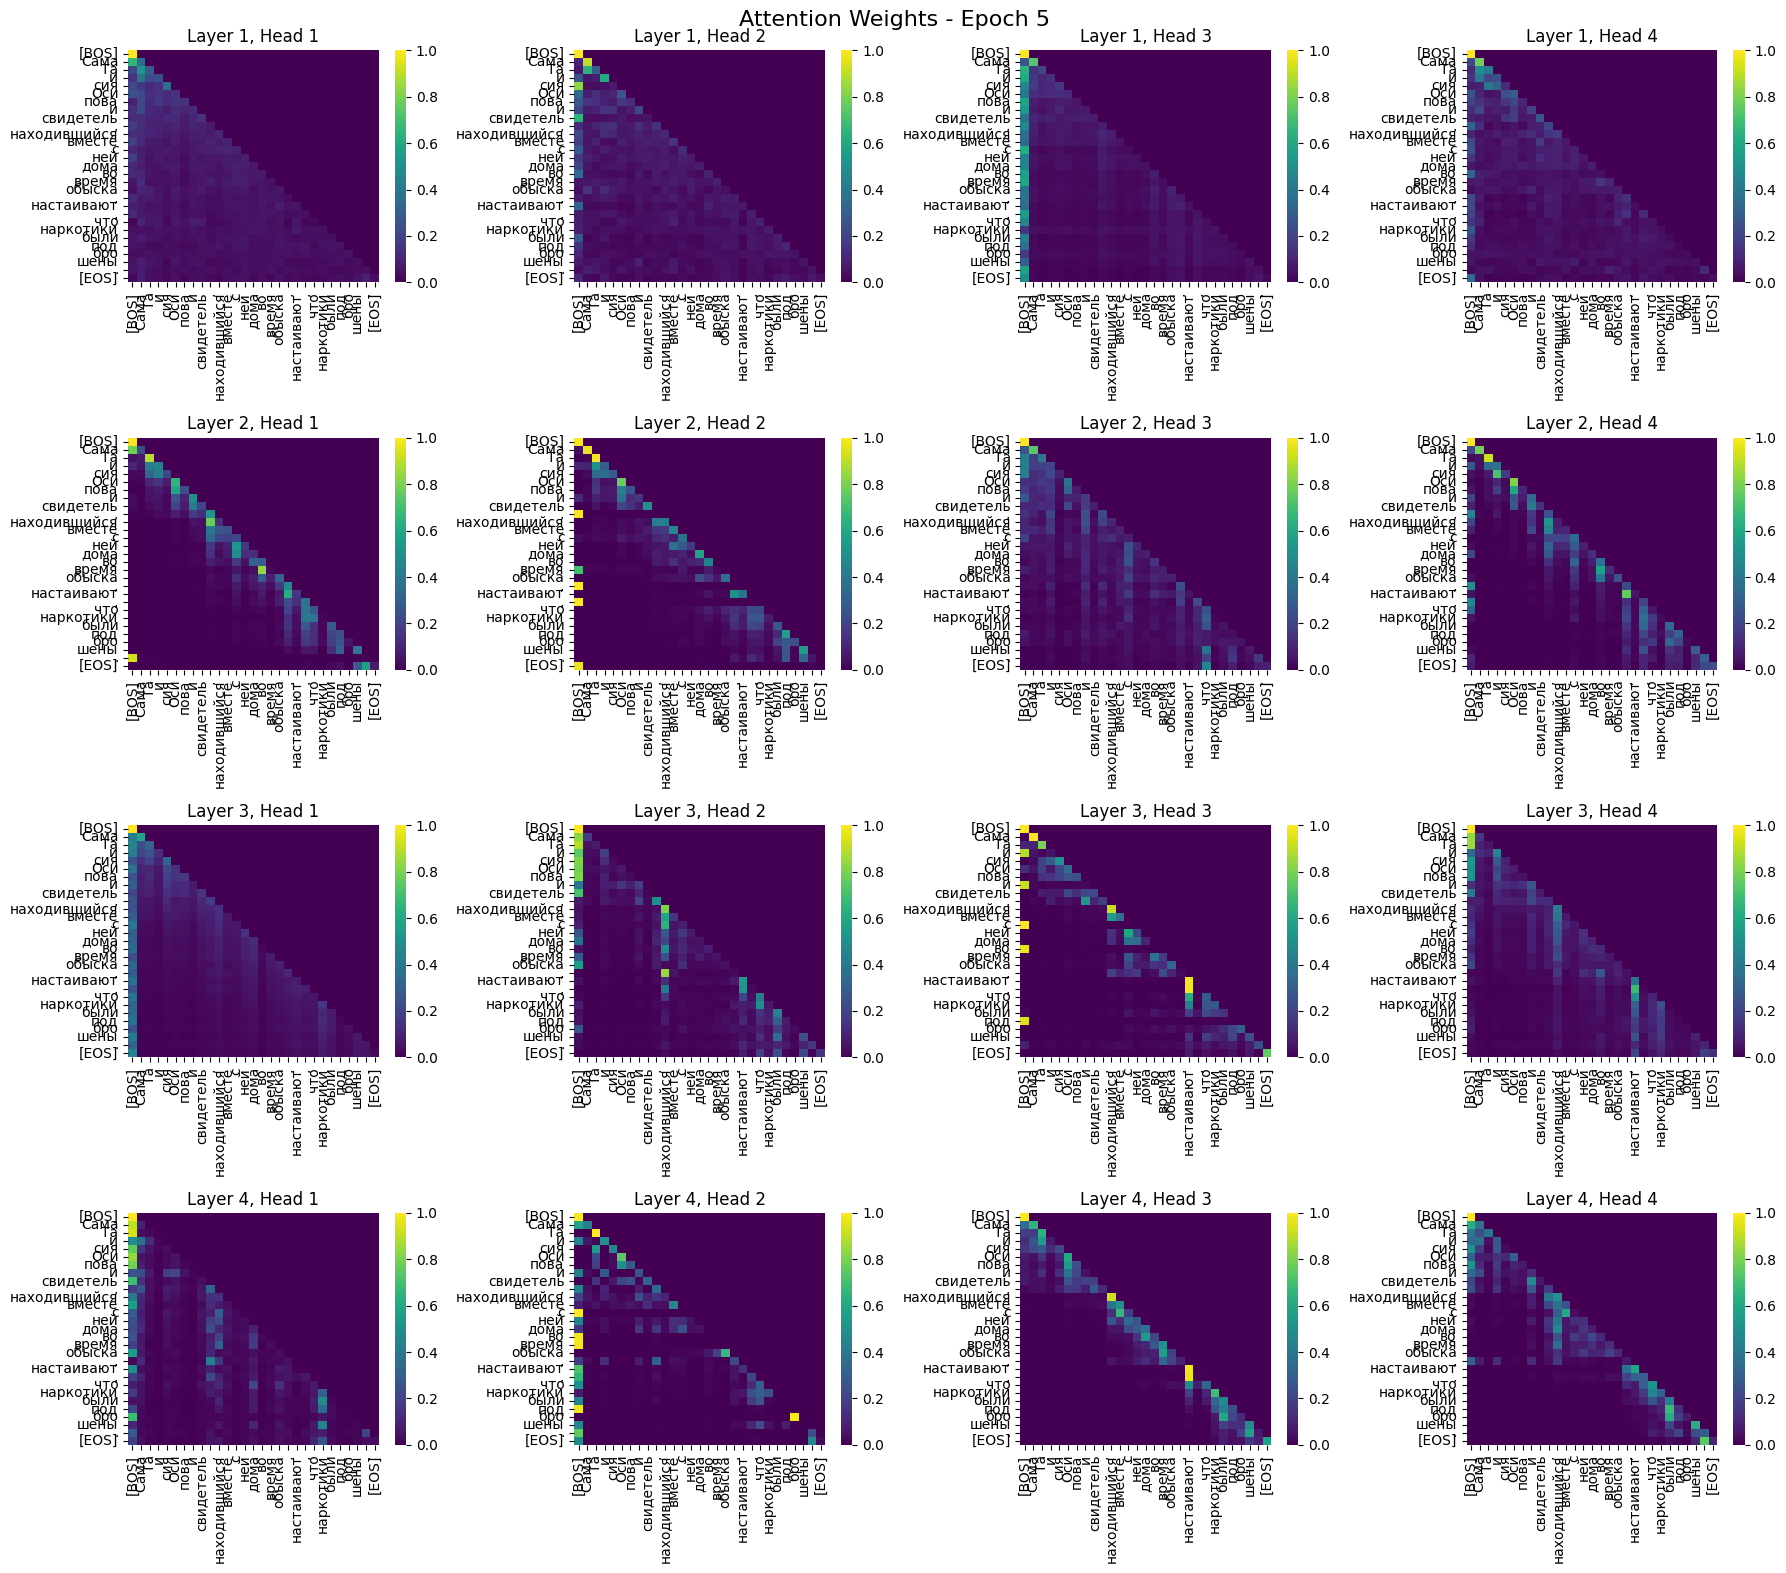

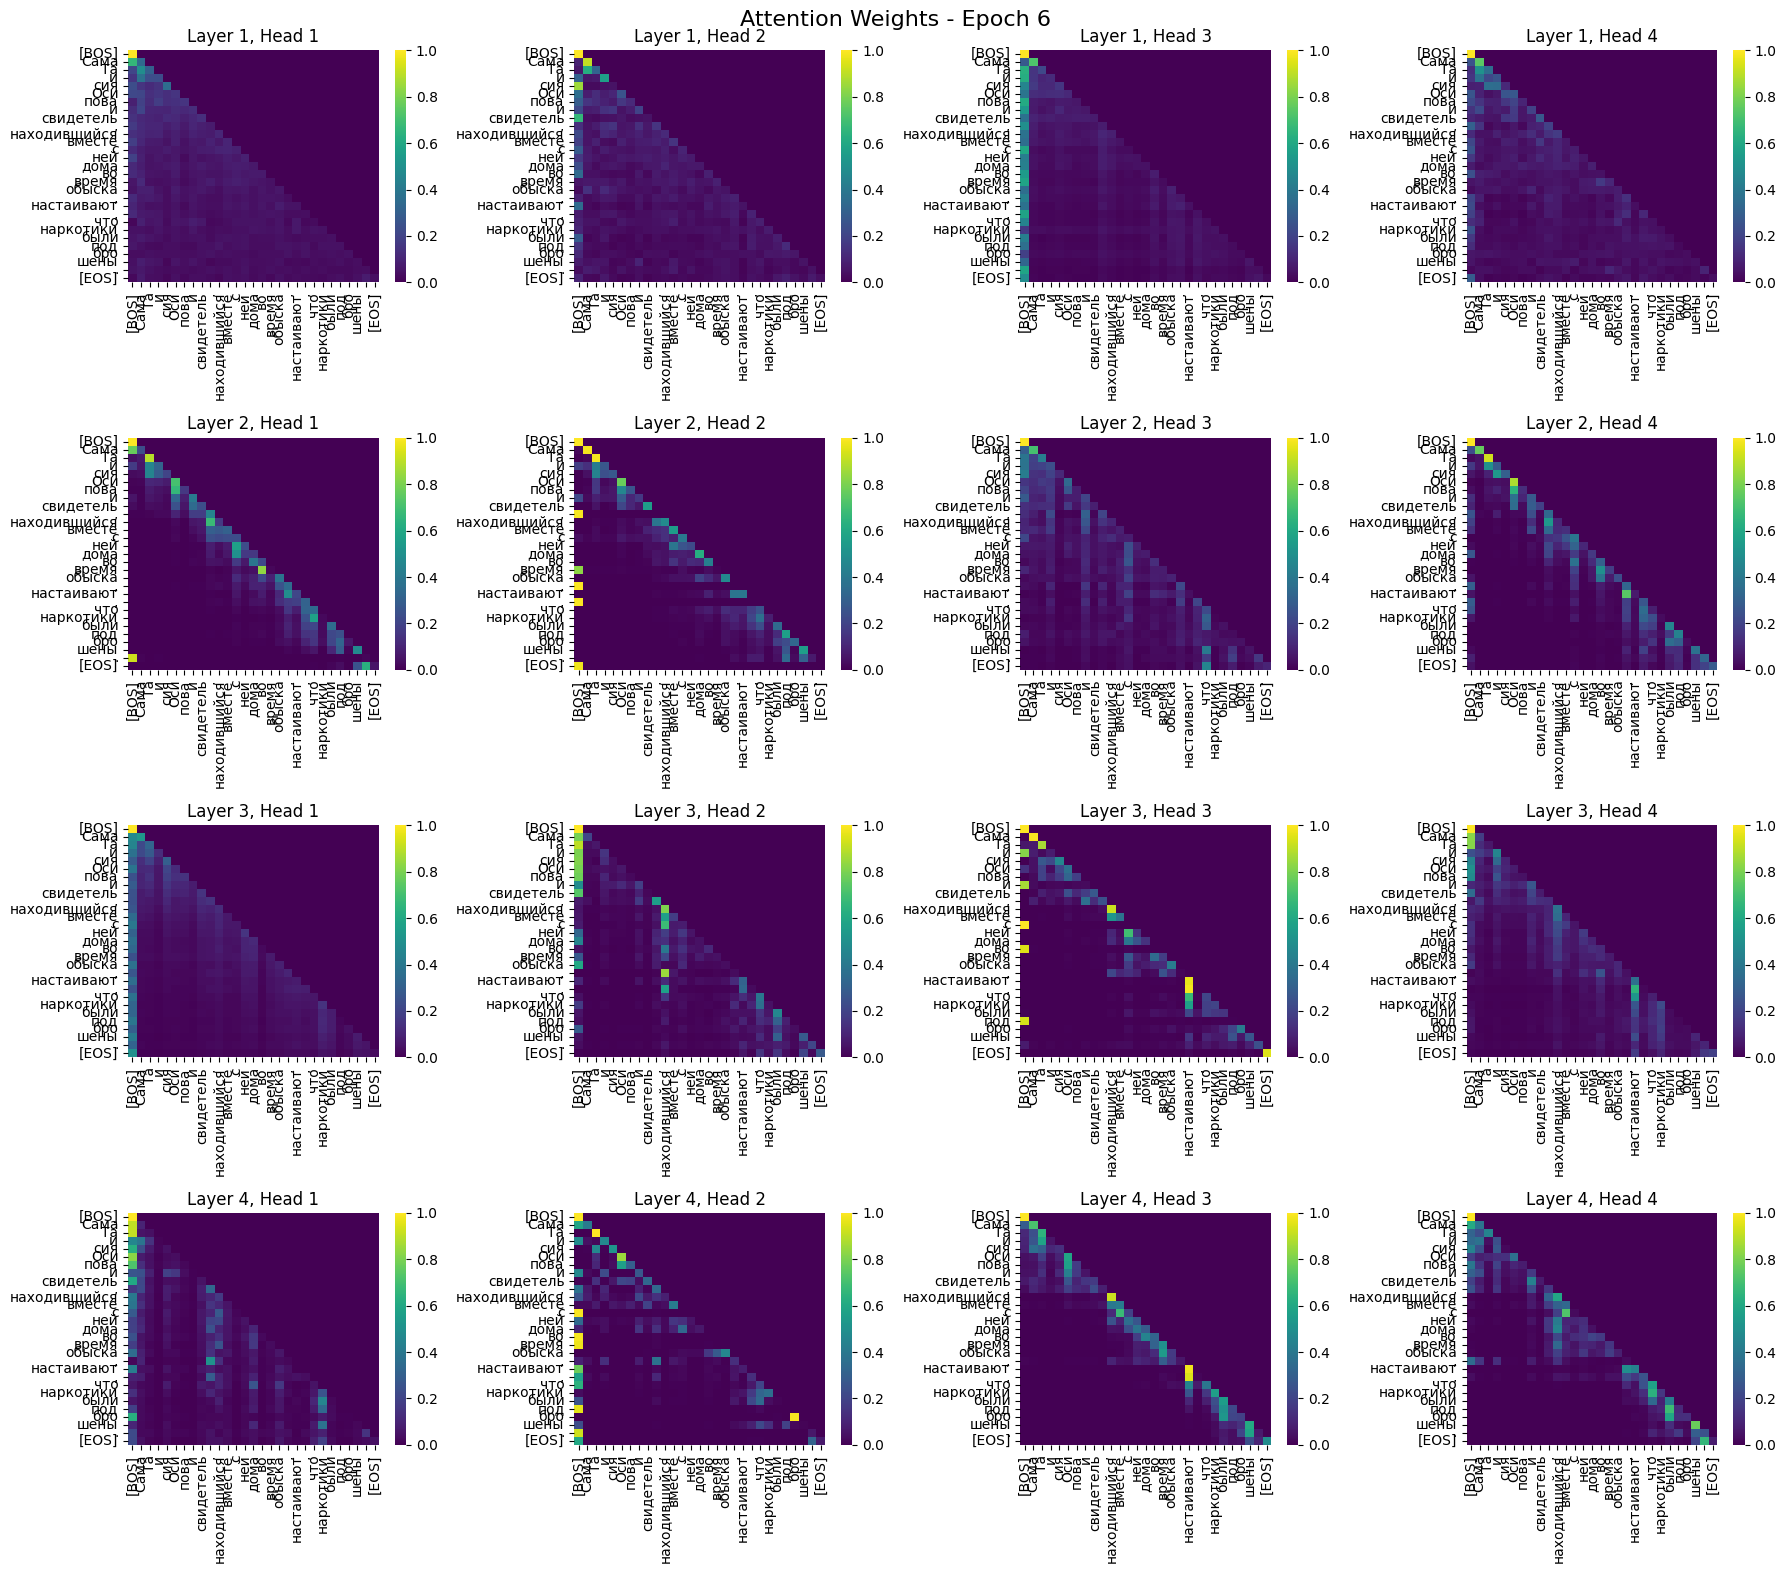

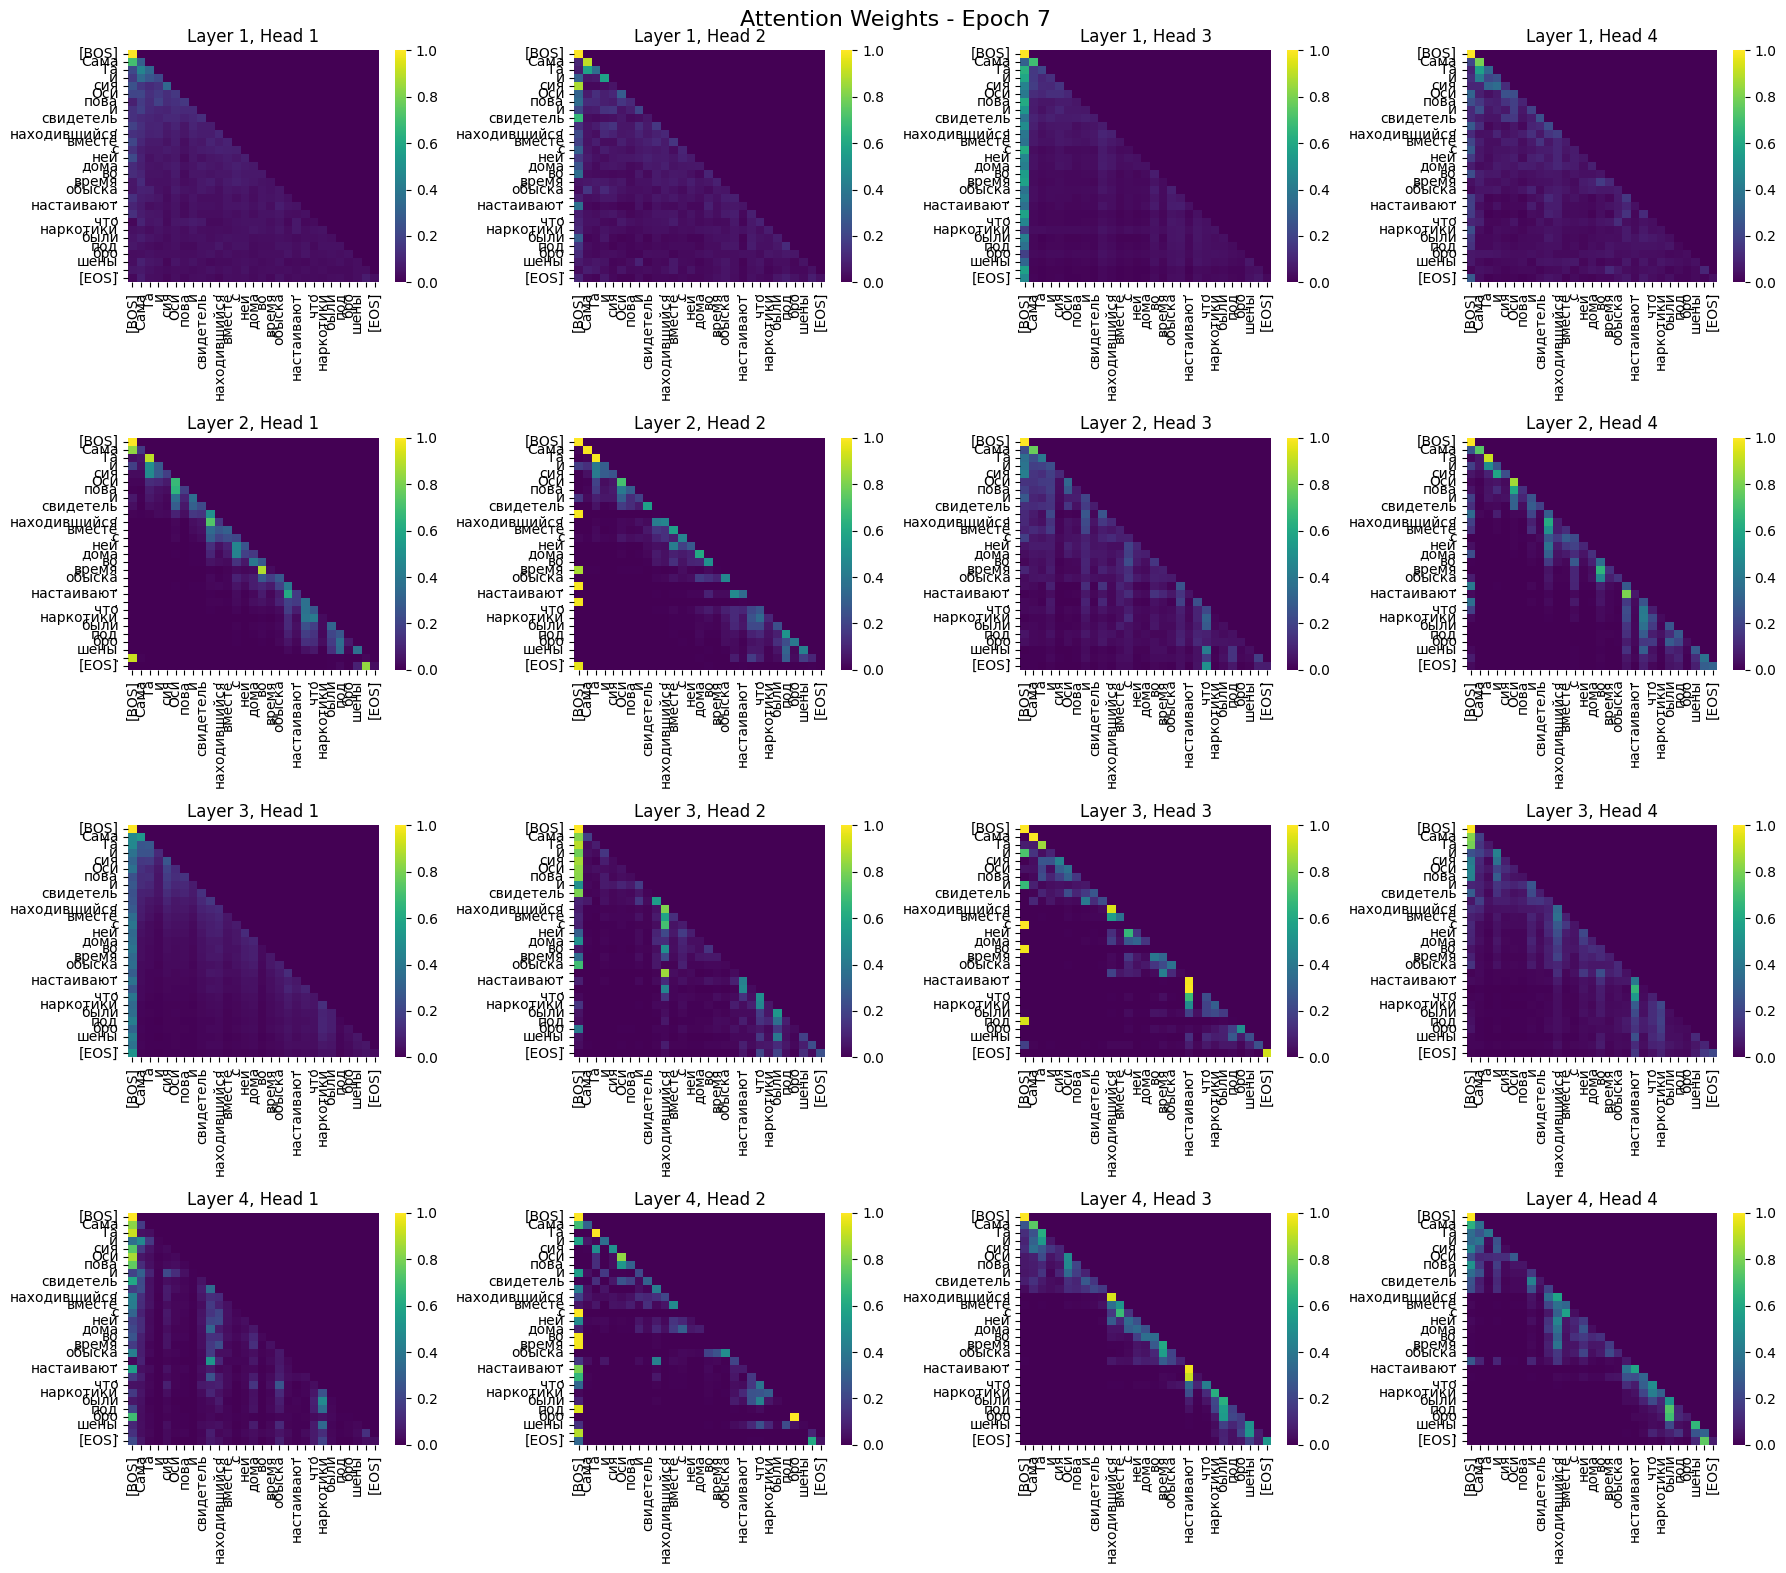

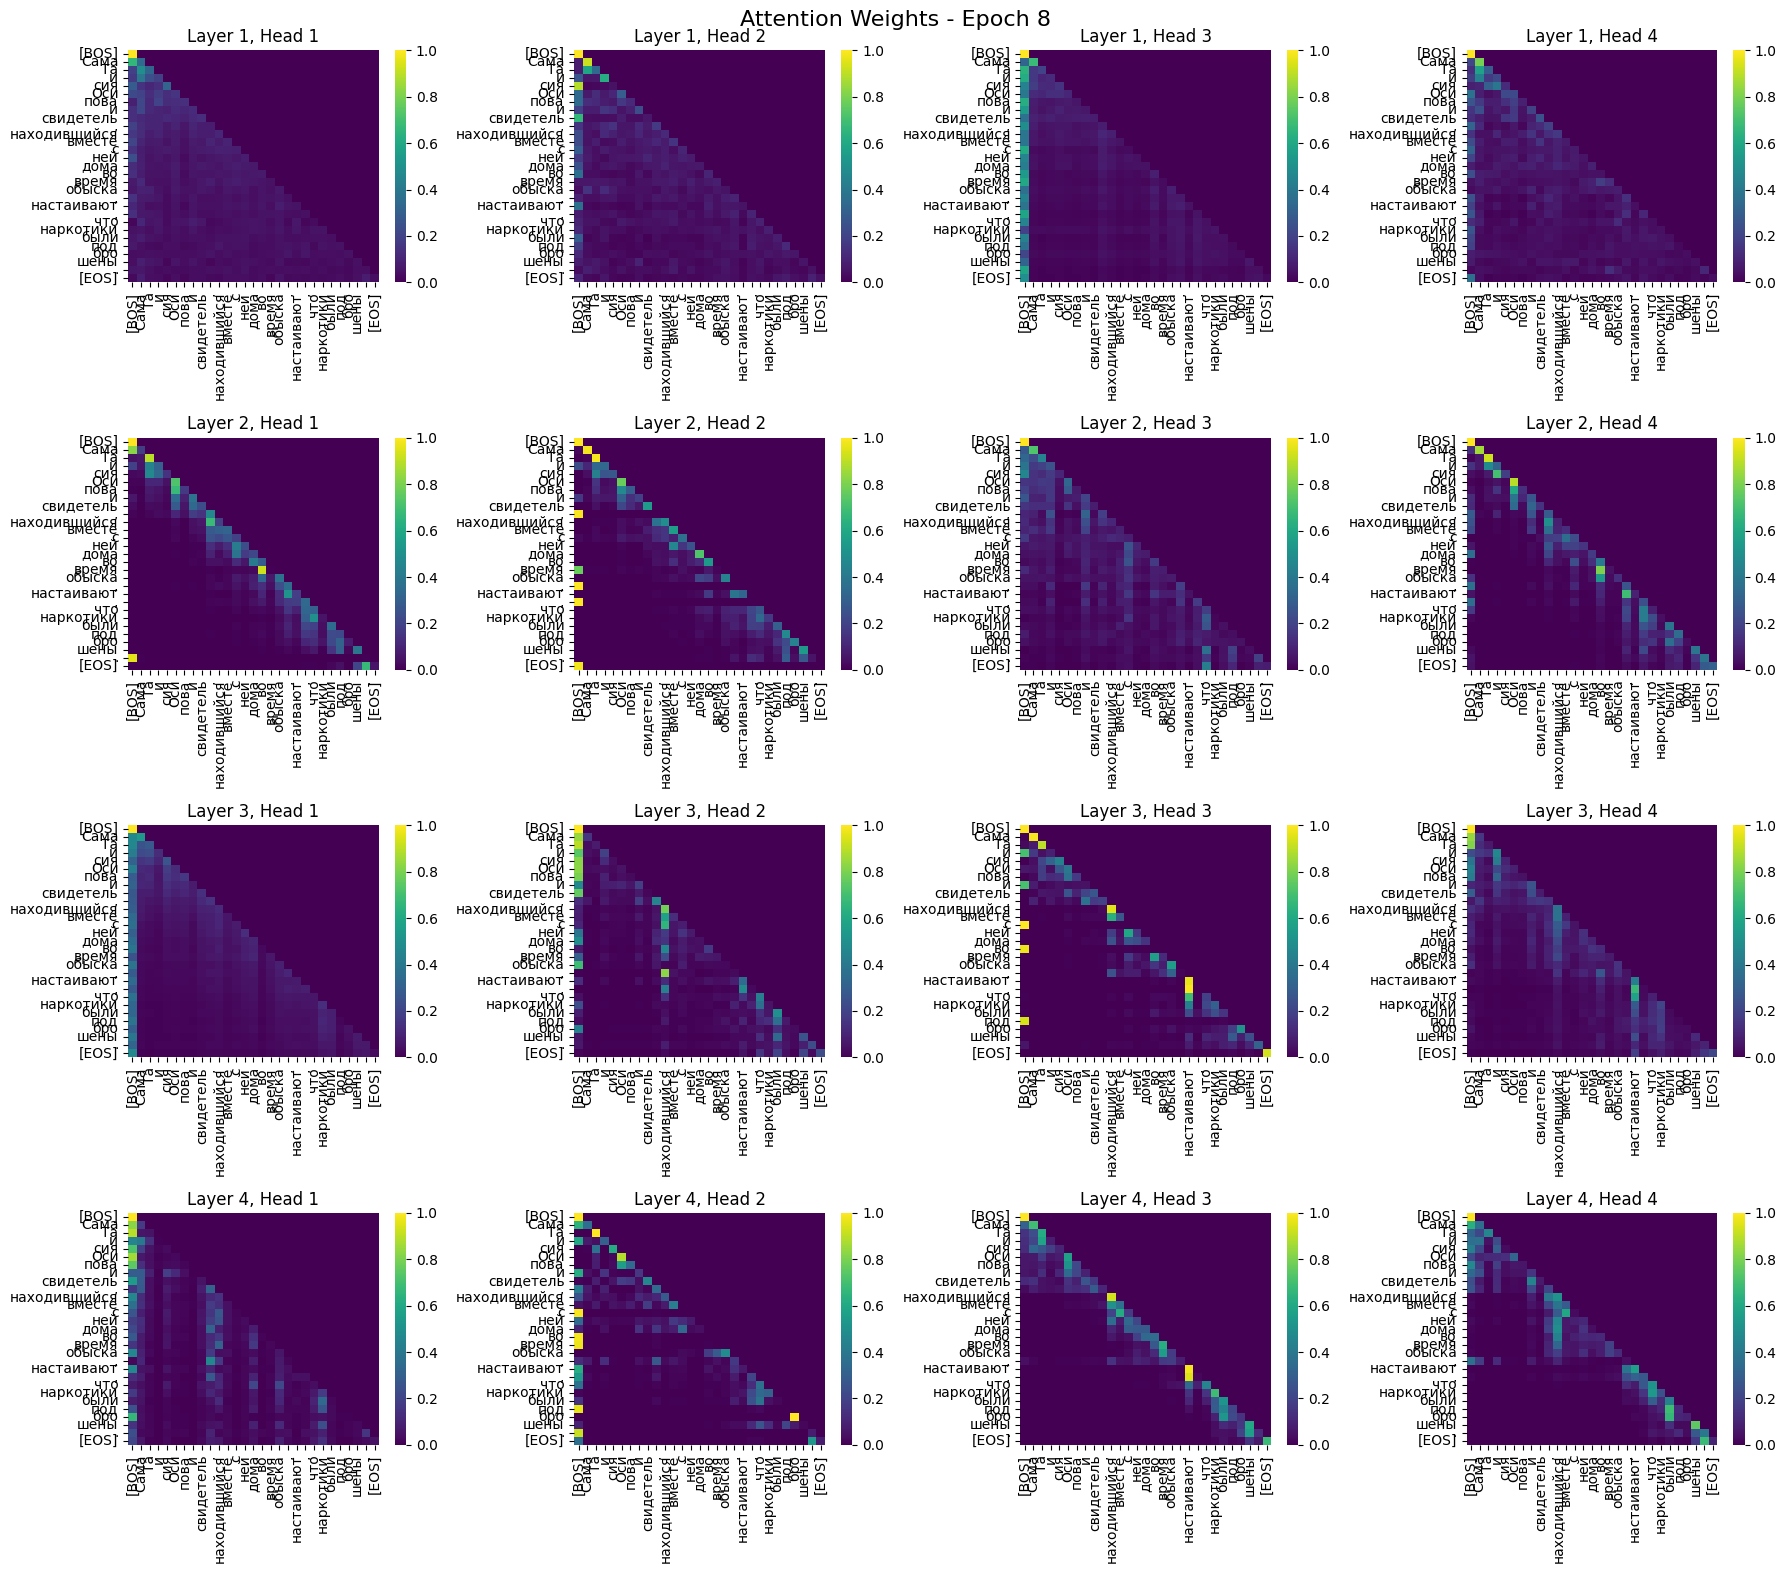

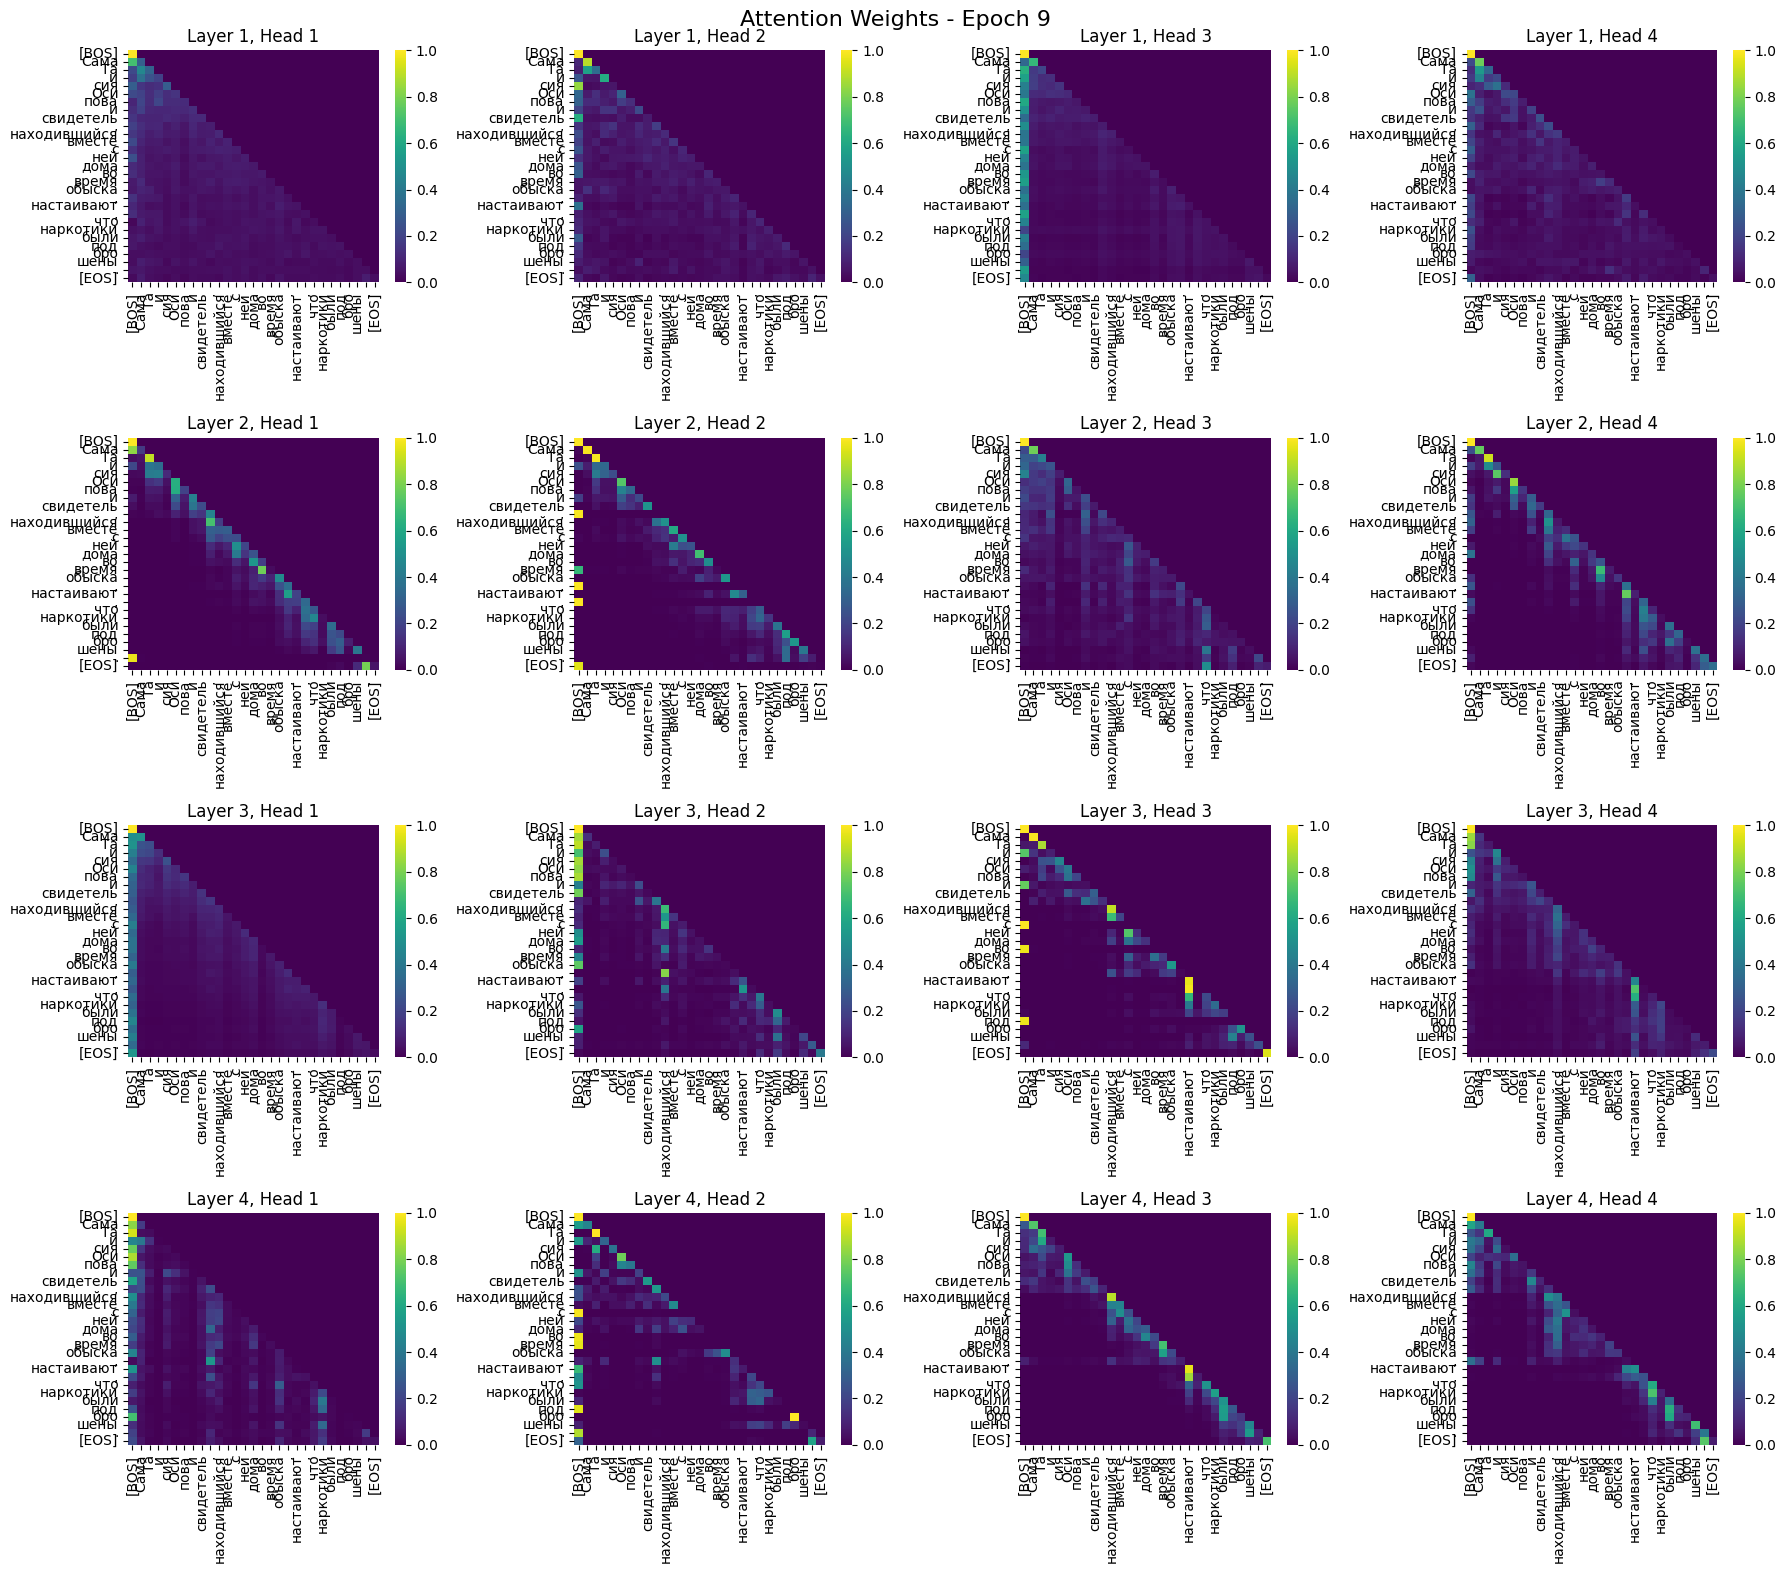

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Визуализируем все эпохи

for epoch in range(len(history_attentions) + 2):
    if epoch >= len(history_attentions):
        continue

    # Убираем размерность батча
    attns = history_attentions[epoch].squeeze(2).numpy()
    n_layer, n_head, T, _ = attns.shape

    fig, axes = plt.subplots(
        n_layer, n_head, figsize=(
            n_head * 4.5, n_layer * 4))
    fig.suptitle(f'Attention Weights - Epoch {epoch}', fontsize=16)

    for l in range(n_layer):
        for h in range(n_head):
            ax = axes[l, h]
            sns.heatmap(attns[l, h], ax=ax, cmap='viridis',
                        xticklabels=tokens_for_viz, yticklabels=tokens_for_viz,
                        cbar=True)
            ax.set_title(f'Layer {l+1}, Head {h+1}')
            ax.tick_params(axis='x', rotation=90)
            ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.show()

## 9. Выводы

В принципе, картина довольно ясная: в начале обучения начинаем с рандомного распределения внимания, фокусе на самих себя, соседей и начала, а к концу заканчиваем тем, что модель уже фокусируется на относительно длинных синтаксических последовательностях.

В начале обучения (эпохи 0-2), у нас шумные матрицы внимания, большинство голов внимания указывают на предшествующие токены (или просто хаотично), а вперёд никто не смотрит. Но даже уже тут в слоях 1-3 видно, что внимание сфокусировано на начальном [BOS] токене. Довольно типичное для трансформеров поведение: пока моделька не выучила какие-то лингвистические паттерны, часто головы внимания указывают на начало. При этом в слоях 2-4 уже есть слабый диагональный паттерн, который показывает, что модель начинает фокусироваться на локальном контексте (соседях).

К середине обучения (эпохи 3-5) модель чётко выучивает локальный контекст. Видно, что модель научилась собирать слова из кусочков, где это релевантно: токен *сия* обращает внимание на *Та* и *и*, куски слова *подброшены* тоже цепляются друг за друга. Ещё модель хорошо связывает базовые пары вроде предлогов с зависимыми словами — токен *время* активно смотрит на *во*, *ней* — на *с*. По сути, на этом этапе некоторые головы уже работают как хорошая биграмная языковая модель, обращая внимание на один-два предыдущих токена.

В конце обучения (эпохи 6-9) начинается самое интересное: глубокие слои (особенно третий) учатся разрешать длинные синтаксические зависимости. Самый классный пример — сказуемое *настаивают*. Видно, что при его обработке модель перекидывает внимание через весь длинный причастный оборот *находившийся вместе с ней* прямо на подлежащие, на конец фамилии *Осипова* и на слово *свидетель*. Аналогичная история в конце предложения, где кусочки слова *подброшены* смотрят через глагол-связку *были* прямо на *наркотики*. То есть модель научилась улавливать общую структуру предложения, а не просто склеивать стоящие рядом слова. Наверное, если бы мы дали несколько предложений и подольше поучили, можно было бы посмотреть и на связи на дискурсивном уровне.